In [35]:
# ----------------------------
# 必要なライブラリをインポート
# ----------------------------
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [36]:
print("=======Input Layer=======")

class VitInputLayer(nn.Module): 
    def __init__(self, in_channels:int=3, emb_dim:int=384, num_patch_row:int=2, image_size:int=32):
        """ 
        引数:
            in_channels: 入力画像のチャンネル数
            emb_dim: 埋め込み後のベクトルの長さ
            num_patch_row: 高さ方向のパッチの数。例は2x2であるため、2をデフォルト値とした 
            image_size: 入力画像の1辺の大きさ。入力画像の高さと幅は同じであると仮定
        """
        super(VitInputLayer, self).__init__() 
        self.in_channels=in_channels 
        self.emb_dim = emb_dim 
        self.num_patch_row = num_patch_row 
        self.image_size = image_size
        
        # パッチの数
        ## 例: 入力画像を2x2のパッチに分ける場合、num_patchは4 
        self.num_patch = self.num_patch_row**2

        # パッチの大きさ
        ## 例: 入力画像の1辺の大きさが32の場合、patch_sizeは16 
        self.patch_size = int(self.image_size // self.num_patch_row)

        # 入力画像のパッチへの分割 & パッチの埋め込みを一気に行う層 
        self.patch_emb_layer = nn.Conv2d(
            in_channels=self.in_channels, 
            out_channels=self.emb_dim, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

        # クラストークン 
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, emb_dim) 
        )

        # 位置埋め込み
        ## クラストークンが先頭に結合されているため、
        ## 長さemb_dimの位置埋め込みベクトルを(パッチ数+1)個用意 
        self.pos_emb = nn.Parameter(
            torch.randn(1, self.num_patch+1, emb_dim) 
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ 
        引数:
            x: 入力画像。形状は、(B, C, H, W)。[式(1)]
                B: バッチサイズ、C:チャンネル数、H:高さ、W:幅
        返り値:
            z_0: ViTへの入力。形状は、(B, N, D)。
                B:バッチサイズ、N:トークン数、D:埋め込みベクトルの長さ
        """
        # パッチの埋め込み & flatten [式(3)]
        ## パッチの埋め込み (B, C, H, W) -> (B, D, H/P, W/P) 
        ## ここで、Pはパッチ1辺の大きさ
        z_0 = self.patch_emb_layer(x)

        ## パッチのflatten (B, D, H/P, W/P) -> (B, D, Np) 
        ## ここで、Npはパッチの数(=H*W/Pˆ2)
        z_0 = z_0.flatten(2)

        ## 軸の入れ替え (B, D, Np) -> (B, Np, D) 
        z_0 = z_0.transpose(1, 2)

        # パッチの埋め込みの先頭にクラストークンを結合 [式(4)] 
        ## (B, Np, D) -> (B, N, D)
        ## N = (Np + 1)であることに留意
        ## また、cls_tokenの形状は(1,1,D)であるため、
        ## repeatメソッドによって(B,1,D)に変換してからパッチの埋め込みとの結合を行う 
        z_0 = torch.cat(
            [self.cls_token.repeat(repeats=(x.size(0),1,1)), z_0], dim=1)

        # 位置埋め込みの加算 [式(5)] 
        ## (B, N, D) -> (B, N, D) 
        z_0 = z_0 + self.pos_emb
        return z_0

=======Input Layer=======


In [51]:
batch_size, channel, height, width= 2, 3, 224, 224
x = torch.randn(batch_size, channel, height, width) 
input_layer = VitInputLayer(num_patch_row=2) 
z_0=input_layer(x)
# (2, 5, 384)(=(B, N, D))になっていることを確認。 
print(z_0.shape)

RuntimeError: ignored

In [38]:
print("=======Self-Attention=======")

class MultiHeadSelfAttention(nn.Module): 
    def __init__(self, emb_dim:int=384, head:int=3, dropout:float=0.):
        """ 
        引数:
            emb_dim: 埋め込み後のベクトルの長さ 
            head: ヘッドの数
            dropout: ドロップアウト率
        """
        super(MultiHeadSelfAttention, self).__init__() 
        self.head = head
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // head
        self.sqrt_dh = self.head_dim**0.5 # D_hの二乗根。qk^Tを割るための係数

        # 入力をq,k,vに埋め込むための線形層。 [式(6)] 
        self.w_q = nn.Linear(emb_dim, emb_dim, bias=False) 
        self.w_k = nn.Linear(emb_dim, emb_dim, bias=False) 
        self.w_v = nn.Linear(emb_dim, emb_dim, bias=False)

        # 式(7)にはないが、実装ではドロップアウト層も用いる 
        self.attn_drop = nn.Dropout(dropout)

        # MHSAの結果を出力に埋め込むための線形層。[式(10)]
        ## 式(10)にはないが、実装ではドロップアウト層も用いる 
        self.w_o = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(dropout) 
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """ 
        引数:
            z: MHSAへの入力。形状は、(B, N, D)。
                B: バッチサイズ、N:トークンの数、D:ベクトルの長さ
        返り値:
            out: MHSAの出力。形状は、(B, N, D)。[式(10)]
                B:バッチサイズ、N:トークンの数、D:埋め込みベクトルの長さ
        """

        batch_size, num_patch, _ = z.size()

        # 埋め込み [式(6)]
        ## (B, N, D) -> (B, N, D)
        q = self.w_q(z)
        k = self.w_k(z)
        v = self.w_v(z)

        # q,k,vをヘッドに分ける [式(10)]
        ## まずベクトルをヘッドの個数(h)に分ける
        ## (B, N, D) -> (B, N, h, D//h)
        q = q.view(batch_size, num_patch, self.head, self.head_dim)
        k = k.view(batch_size, num_patch, self.head, self.head_dim)
        v = v.view(batch_size, num_patch, self.head, self.head_dim)

        ## Self-Attentionができるように、
        ## (バッチサイズ、ヘッド、トークン数、パッチのベクトル)の形に変更する 
        ## (B, N, h, D//h) -> (B, h, N, D//h)
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        # 内積 [式(7)]
        ## (B, h, N, D//h) -> (B, h, D//h, N)
        k_T = k.transpose(2, 3)
        ## (B, h, N, D//h) x (B, h, D//h, N) -> (B, h, N, N) 
        dots = (q @ k_T) / self.sqrt_dh
        ## 列方向にソフトマックス関数
        attn = F.softmax(dots, dim=-1)
        ## ドロップアウト
        attn = self.attn_drop(attn)
        # 加重和 [式(8)]
        ## (B, h, N, N) x (B, h, N, D//h) -> (B, h, N, D//h) 
        out = attn @ v
        ## (B, h, N, D//h) -> (B, N, h, D//h)
        out = out.transpose(1, 2)
        ## (B, N, h, D//h) -> (B, N, D)
        out = out.reshape(batch_size, num_patch, self.emb_dim)

        # 出力層 [式(10)]
        ## (B, N, D) -> (B, N, D) 
        out = self.w_o(out) 
        return out

=======Self-Attention=======


In [39]:
mhsa = MultiHeadSelfAttention()
out = mhsa(z_0) #z_0は2-2節のz_0=input_layer(x)で、形状は(B, N, D)
# (2, 5, 384)(=(B, N, D))になっていることを確認 
print(out.shape)

torch.Size([2, 5, 384])


In [40]:
print("=======Encoder=======")

class VitEncoderBlock(nn.Module): 
    def __init__(self, emb_dim:int=384, head:int=8, hidden_dim:int=384*4, dropout: float=0.):
        """
        引数:
            emb_dim: 埋め込み後のベクトルの長さ
            head: ヘッドの数
            hidden_dim: Encoder BlockのMLPにおける中間層のベクトルの長さ 
                        原論文に従ってemb_dimの4倍をデフォルト値としている
            dropout: ドロップアウト率
        """
        super(VitEncoderBlock, self).__init__()
        # 1つ目のLayer Normalization [2-5-2項]
        self.ln1 = nn.LayerNorm(emb_dim)
        # MHSA [2-4-7項]
        self.msa = MultiHeadSelfAttention(
        emb_dim=emb_dim, head=head,
        dropout = dropout,
        )
        # 2つ目のLayer Normalization [2-5-2項] 
        self.ln2 = nn.LayerNorm(emb_dim)
        # MLP [2-5-3項]
        self.mlp = nn.Sequential( 
            nn.Linear(emb_dim, hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, emb_dim), 
            nn.Dropout(dropout)
        )
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """ 
        引数:
            z: Encoder Blockへの入力。形状は、(B, N, D)
                B: バッチサイズ、N:トークンの数、D:ベクトルの長さ
        返り値:
            out: Encoder Blockへの出力。形状は、(B, N, D)。[式(10)]
                B:バッチサイズ、N:トークンの数、D:埋め込みベクトルの長さ 
        """
        # Encoder Blockの前半部分 [式(12)] 
        out = self.msa(self.ln1(z)) + z
        # Encoder Blockの後半部分 [式(13)] 
        out = self.mlp(self.ln2(out)) + out 
        return out

=======Encoder=======


In [41]:
vit_enc = VitEncoderBlock()
z_1 = vit_enc(z_0) #z_0は2-2節のz_0=input_layer(x)で、形状は(B, N, D)
# (2, 5, 384)(=(B, N, D))になっていることを確認 
print(z_1.shape)

torch.Size([2, 5, 384])


In [42]:
print("=======ViTの実装=======")

class Vit(nn.Module): 
    def __init__(self, in_channels:int=3, num_classes:int=10, emb_dim:int=384, num_patch_row:int=2, image_size:int=32, num_blocks:int=7, head:int=8, hidden_dim:int=384*4, dropout:float=0.):
        """ 
        引数:
            in_channels: 入力画像のチャンネル数
            num_classes: 画像分類のクラス数
            emb_dim: 埋め込み後のベクトルの長さ
            num_patch_row: 1辺のパッチの数
            image_size: 入力画像の1辺の大きさ。入力画像の高さと幅は同じであると仮定 
            num_blocks: Encoder Blockの数
            head: ヘッドの数
            hidden_dim: Encoder BlockのMLPにおける中間層のベクトルの長さ 
            dropout: ドロップアウト率
        """
        super(Vit, self).__init__()
        # Input Layer [2-3節] 
        self.input_layer = VitInputLayer(
            in_channels, 
            emb_dim, 
            num_patch_row, 
            image_size)

        # Encoder。Encoder Blockの多段。[2-5節] 
        self.encoder = nn.Sequential(*[
            VitEncoderBlock(
                emb_dim=emb_dim,
                head=head,
                hidden_dim=hidden_dim,
                dropout = dropout
            )
            for _ in range(num_blocks)])

        # MLP Head [2-6-1項] 
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        引数:
            x: ViTへの入力画像。形状は、(B, C, H, W)
                B: バッチサイズ、C:チャンネル数、H:高さ、W:幅
        返り値:
            out: ViTの出力。形状は、(B, M)。[式(10)]
                B:バッチサイズ、M:クラス数 
        """
        # Input Layer [式(14)]
        ## (B, C, H, W) -> (B, N, D)
        ## N: トークン数(=パッチの数+1), D: ベクトルの長さ 
        out = self.input_layer(x)
        
        # Encoder [式(15)、式(16)]
        ## (B, N, D) -> (B, N, D)
        out = self.encoder(out)

        # クラストークンのみ抜き出す
        ## (B, N, D) -> (B, D)
        cls_token = out[:,0]

        # MLP Head [式(17)]
        ## (B, D) -> (B, M)
        pred = self.mlp_head(cls_token)
        return pred

=======ViTの実装=======


In [43]:
num_classes = 10
batch_size, channel, height, width= 2, 3, 32, 32
x = torch.randn(batch_size, channel, height, width)
vit = Vit(in_channels=channel, num_classes=num_classes) 
pred = vit(x)
# (2, 10)(=(B, M))になっていることを確認 
print(pred.shape)

torch.Size([2, 10])


In [52]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [53]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=train_transforms,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=val_transforms,
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 224, 224])
6


In [55]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

In [56]:
!pip install timm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = Vit().to(device)

import timm

net = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)
net.to("cuda:0")

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=3e-5)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [61]:
print(device)
net

cuda


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

In [ ]:
from tqdm import tqdm
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        #view()での変換をしない
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

  5%|▌         | 1/20 [09:14<2:55:42, 554.85s/it]

Epoch [1/20], Loss: 0.0053, val_loss: 0.0012, val_acc: 0.9738


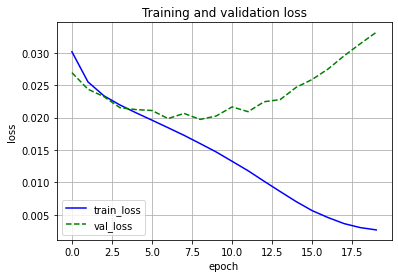

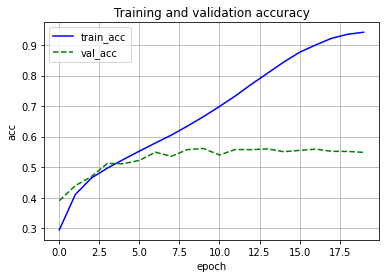

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()